# Deep Learning Models

Authored by [witchapong](https://github.com/witchapong); Edited by [cstorm125](https://github.com/cstorm125/)

This notebook details how to tackle the recommendation problem using deep learning models. We provide two example models: one where all variables are treated as cross-sectional variables, and the other where previous snaps are treated as sequential variables.

In [ ]:
# #uncomment if you are running from google colab
# !wget https://github.com/Datatouille/snaplogic_snap_recommendation/archive/master.zip; unzip master
# !mv snaplogic_snap_recommendation-master/* .
# !ls

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import *
np.set_printoptions(threshold=50, edgeitems=20)

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

In [2]:
train_df = pd.read_csv("train_df.csv")
valid_df = pd.read_csv("valid_df.csv")
submit_df = pd.read_csv("submit_df.csv")
all_df = pd.concat([train_df,valid_df,submit_df],0).reset_index(drop=True)
train_df.shape, valid_df.shape, submit_df.shape

((103112, 9), (14731, 9), (29461, 9))

In [3]:
train_df.head()

,date,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
0,2014-12-05,4,0,0,0,0,145,195,59
1,2014-12-05,4,178,195,0,0,145,240,59
2,2014-12-05,4,195,0,0,0,145,178,59
3,2015-02-10,4,240,223,88,0,414,195,59
4,2015-02-10,4,88,0,0,0,414,223,59


In [4]:
train_df.describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000
mean,2.290994,196.070661,141.378404,94.487072,56.880169,197.992271,282.422347,117.850114
std,0.755975,145.820540,153.465324,142.909668,119.606031,95.240417,128.184887,57.546317
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,18.000000,0.000000,0.000000,0.000000,170.000000,212.000000,82.000000
50%,2.000000,240.000000,88.000000,0.000000,0.000000,170.000000,240.000000,90.000000
75%,2.000000,279.000000,240.000000,224.000000,0.000000,170.000000,416.000000,192.000000
max,4.000000,485.000000,485.000000,485.000000,485.000000,506.000000,485.000000,217.000000


## Cross-sectional Model

In this model, our features are indice of previous snaps, organizations, projects and users. We treat all of them as cross-sectional, categorical variables. The output of the model is the probability of the target snap.

### Dataloaders

We create dataloaders for train and validation sets. They simply output each row of the dataframe.

In [5]:
class SnapStaDataset(Dataset):
    def __init__(self, df, sta_cols, target_col):
        self.df  = df
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [6]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [7]:
next(iter(train_dl))

[tensor([[  0,   0,   0,  ...,   2, 170,  90],
         [  0,   0,   0,  ...,   2, 170,  31],
         [283, 283, 283,  ...,   2, 170, 192],
         ...,
         [  0,   0,   0,  ...,   2, 135,  82],
         [  0, 214, 317,  ...,   2, 170, 192],
         [  0,   0,   0,  ...,   2, 170, 192]], device='cuda:0'),
 tensor([224, 120, 240,  ..., 223, 461, 416], device='cuda:0')]

### Architecture

The architecture consists of embedding layers that convert all categorical indice to tensors then concatenate them together. After that, we put the concatenated tensors through non-linearity layers, lastly, outputing probabilities for the target snap.

In [8]:
sta_dict = {'prev_snap_4': 486, 'prev_snap_3': 486, 'prev_snap_2': 486, 'prev_snap_1': 486,
            'org':5, 'project':507, 'user':218}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 486}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSta(nn.Module):
    def __init__(self, config, sta_dict):
        super(RecommendSta, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.emb_p = config['emb_p']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict])
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #linear
        res = self.fc_layers(sta_out)
        res = self.head(res)
    
        return(res)

In [10]:
model = RecommendSta(config, sta_dict).to(device)
x = next(iter(valid_dl))
sta_input = x[0]
target = x[1]
model(sta_input).shape

torch.Size([14731, 486])

In [11]:
model

RecommendSta(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(486, 51)
    (1): Embedding(486, 51)
    (2): Embedding(486, 51)
    (3): Embedding(486, 51)
    (4): Embedding(5, 4)
    (5): Embedding(507, 52)
    (6): Embedding(218, 33)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=293, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=486, bias=True)
)

### Training

We perform training with a high learning rate then gradually lowers it as validation loss stagnates.

In [12]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [13]:
sta_dict = {'prev_snap_4': 486, 'prev_snap_3': 486, 'prev_snap_2': 486, 'prev_snap_1': 486,
            'org':5, 'project':507, 'user':218}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 486}

model = RecommendSta(config, sta_dict).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [15]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.cpu().detach().numpy()
        probs = F.softmax(score,1).cpu().detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 2.275 valid loss: 2.174            accuracy: 0.459  top-5 accuracy: 0.76
1 train loss: 2.12 valid loss: 2.117            accuracy: 0.46  top-5 accuracy: 0.783
2 train loss: 2.026 valid loss: 2.091            accuracy: 0.471  top-5 accuracy: 0.784
3 train loss: 1.965 valid loss: 2.064            accuracy: 0.475  top-5 accuracy: 0.782
4 train loss: 1.916 valid loss: 2.056            accuracy: 0.482  top-5 accuracy: 0.79
5 train loss: 1.882 valid loss: 2.039            accuracy: 0.486  top-5 accuracy: 0.793
6 train loss: 1.855 valid loss: 2.022            accuracy: 0.482  top-5 accuracy: 0.795
7 train loss: 1.826 valid loss: 2.016            accuracy: 0.489  top-5 accuracy: 0.796
8 train loss: 1.806 valid loss: 2.049            accuracy: 0.495  top-5 accuracy: 0.795
9 train loss: 1.788 valid loss: 2.018            accuracy: 0.488  top-5 accuracy: 0.802
10 train loss: 1.711 valid loss: 1.989            accuracy: 0.5  top-5 accuracy: 0.802
11 train loss: 1.681 valid loss: 1.99

In [ ]:
#save model
# torch.save(best_weights,'sta_weights.pth')

### Diagnostics

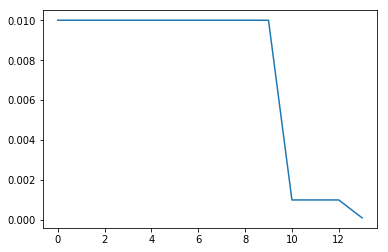

In [16]:
plt.plot(lrs)

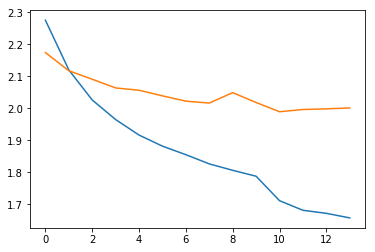

In [17]:
plt.plot(train_losses)
plt.plot(valid_losses)

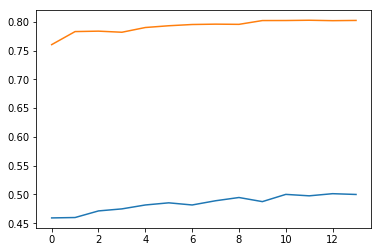

In [18]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluations

With 486 target classes, it is almost impossible to diagnose how well your model performs by looking at confusion matrix like you would normally do. Here we provide the idea of an "accuracy curve" as possible model evaluation tool.

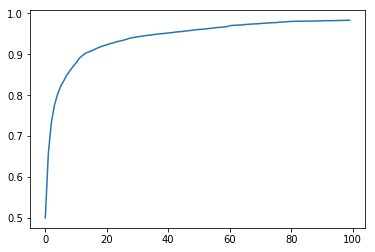

In [21]:
#accurayc curve
acc_curve_sta = []
for i in tqdm_notebook(range(1,101)):
    acc_curve_sta.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve_sta)

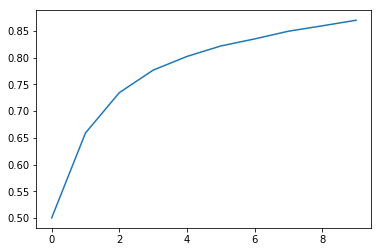

In [22]:
plt.plot(acc_curve_sta[:10])

## Sequential Model

The model is essentially the same as cross-sectional model, except for the fact that we treat `prev_snap_4` to `prev_snap_1` as sequential categorical features, and put them through recurrent layers. `org`, `project`, and `user` are treated the same way as cross-sectional model.

### Dataloaders

This dataloader will output a tuple of three elements: (`sequential variables`, `cross-sectional variables`, `target`).

In [23]:
class SnapSeqDataset(Dataset):
    def __init__(self, df, seq_cols, sta_cols, target_col):
        self.df  = df
        self.seq = df[seq_cols]
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.seq.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [24]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [25]:
next(iter(train_dl))

[tensor([[  0,   0,   0,   0],
         [  0,   0, 226, 240],
         [  0,   0, 243, 240],
         ...,
         [  0,   0,   0,   0],
         [416, 240, 433, 279],
         [  0,   0,   0,   0]], device='cuda:0'), tensor([[  2, 484,  82],
         [  2, 170,  82],
         [  2, 170,  90],
         ...,
         [  2, 170,  82],
         [  2, 170,  31],
         [  3, 480, 199]], device='cuda:0'), tensor([ 66, 368, 240,  ..., 126,  30,  88], device='cuda:0')]

### Architecture

Same as before, we put all categorical indice through embedding layers to get embedding tensors. But before we concatenate them together and put them through non-linearity layers, we put the sequential variables through recurrent layers.

In [37]:
sta_dict = {'org':5, 'project':507, 'user':218}
seq_dim = 486
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 486}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSeq(nn.Module):
    def __init__(self, config, sta_dict, seq_dim):
        super(RecommendSeq, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.seq_dim = seq_dim
        self.emb_p = config['emb_p']
        self.rnn_p = config['rnn_p']
        self.rnn_l = config['rnn_l']
        self.rnn_h = config['rnn_h']
        self.seq_len = config['seq_len']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.seq_layer = nn.Embedding(seq_dim, emb_sz_rule(seq_dim))
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict]) + self.rnn_h * self.seq_len
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #recurrent layers
        self.rnn_layers = nn.LSTM(emb_sz_rule(seq_dim), self.rnn_h,
                                   num_layers = self.rnn_l, bias=True, batch_first=True,
                                   dropout=self.rnn_p)
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, seq_input, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #seq
        bs = seq_input.shape[0]
        seq_out = self.seq_layer(seq_input)
        seq_out = self.emb_drop(seq_out)
        seq_out, seq_h = self.rnn_layers(seq_out)
        seq_out = seq_out.contiguous()
        seq_out = seq_out.view(bs,-1)
        
        #linear
        lin_in = torch.cat([sta_out,seq_out],1)
        res = self.fc_layers(lin_in)
        res = self.head(res)
        
        return(res)

In [38]:
model = RecommendSeq(config, sta_dict, seq_dim).to(device)
x = next(iter(valid_dl))
seq_input = x[0]
sta_input = x[1]
target = x[2]
model(seq_input,sta_input).shape

torch.Size([14731, 486])

In [39]:
model

RecommendSeq(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(507, 52)
    (2): Embedding(218, 33)
  )
  (seq_layer): Embedding(486, 51)
  (rnn_layers): LSTM(51, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=4089, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=486, bias=True)
)

### Training

We perform training with a high learning rate then gradually lowers it as validation loss stagnates.

In [40]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [41]:
sta_dict = {'org':5, 'project':507, 'user':218}
seq_dim = 486
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 486}

model = RecommendSeq(config, sta_dict, seq_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [42]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.cpu().detach().numpy()
        probs = F.softmax(score,1).cpu().detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 3.051 valid loss: 2.432            accuracy: 0.415  top-5 accuracy: 0.722
1 train loss: 2.314 valid loss: 2.179            accuracy: 0.455  top-5 accuracy: 0.768
2 train loss: 2.098 valid loss: 2.103            accuracy: 0.472  top-5 accuracy: 0.769
3 train loss: 1.974 valid loss: 2.032            accuracy: 0.491  top-5 accuracy: 0.784
4 train loss: 1.897 valid loss: 2.025            accuracy: 0.49  top-5 accuracy: 0.794
5 train loss: 1.837 valid loss: 2.009            accuracy: 0.489  top-5 accuracy: 0.791
6 train loss: 1.799 valid loss: 1.997            accuracy: 0.502  top-5 accuracy: 0.796
7 train loss: 1.767 valid loss: 1.985            accuracy: 0.5  top-5 accuracy: 0.797
8 train loss: 1.733 valid loss: 1.971            accuracy: 0.502  top-5 accuracy: 0.798
9 train loss: 1.715 valid loss: 1.992            accuracy: 0.502  top-5 accuracy: 0.797
10 train loss: 1.692 valid loss: 1.99            accuracy: 0.505  top-5 accuracy: 0.799
11 train loss: 1.604 valid loss: 1.

In [ ]:
#save model
# torch.save(best_weights,'seq_weights.pth')

### Diagnostics

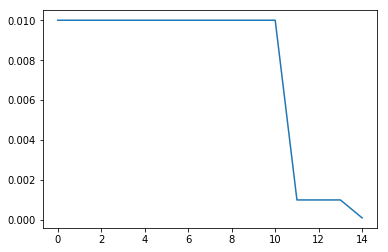

In [43]:
plt.plot(lrs)

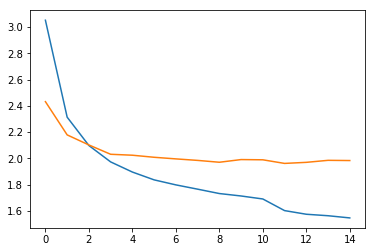

In [44]:
plt.plot(train_losses)
plt.plot(valid_losses)

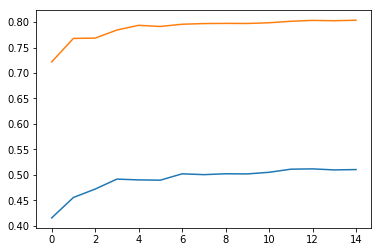

In [45]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluation

Here we can also compare performance between cross-sectional and sequential models. You can see they are very close.

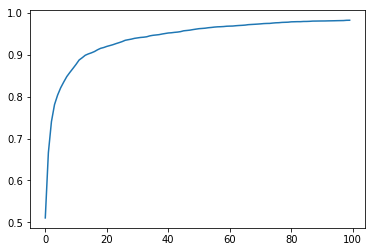

In [46]:
#accurayc curve
acc_curve_seq = []
for i in tqdm_notebook(range(1,101)):
    acc_curve_seq.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve_seq)

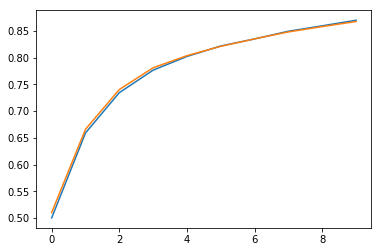

In [48]:
plt.plot(acc_curve_sta[:10])
plt.plot(acc_curve_seq[:10])